In [31]:
import pandas as pd
import numpy as np
from my_pysyncon import Dataprep, Synth, AugSynth

In [32]:
# import the data

df_mo = pd.read_csv('../../../SharedData/total_state_data.csv')
df_yr = pd.read_csv('../../../SharedData/yearly_total_data.csv')

In [33]:
# add a bunch of features (these will eventually get moved to combine_files.ipynb)

df_mo['co2_per_capita'] = df_mo['monthly_emissions'] / df_mo['monthly_population']
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp'] / df_mo['monthly_population']
df_mo['eprod_per_capita'] = df_mo['monthly_energy_prod'] / df_mo['monthly_population']
df_mo['eflow_per_capita'] = df_mo['monthly_energy_flow'] / df_mo['monthly_population']
df_mo['num_plants_per_capita'] = df_mo['monthly_num_plants'] / df_mo['monthly_population']


df_yr['co2_per_capita'] = df_yr['total_co2'] / df_yr['yearly_population']
df_yr['gdp_per_capita'] = df_yr['yearly_gdp_rel_2017'] / df_yr['yearly_population']
df_yr['eprod_per_capita'] = df_yr['yearly_energy_prod'] / df_yr['yearly_population']
df_yr['eflow_per_capita'] = df_yr['yearly_energy_flow'] / df_yr['yearly_population']
df_yr['num_plants_per_capita'] = df_yr['yearly_num_plants'] / df_yr['yearly_population']

In [34]:
# set number of months to skip at a time when training monthly model.
# month_jumps = 1 means consider all monthly data; month_jumps = 12 means consider one month per year
month_jumps = 1

# these are the time values where CO2 per capita is fit
preintervention_time_range = df_mo.date[(df_mo.date >= '1990-06-01')&(df_mo.date<'2009-01-01')&(df_mo.state=='MI')][::month_jumps]

# these are the time values where our features are fit (subset of preintervention_time_range)
preintervention_feature_range = df_mo.date[(df_mo.date >= '1997-01-01') & (df_mo.date<'2009-01-01')&(df_mo.state=='MI')][::month_jumps]
preintervention_weather_range = df_mo.date[(df_mo.date >= '1990-01-01') & (df_mo.date<'2009-01-01')&(df_mo.state=='MI')][::month_jumps]
preintervention_gdp_range = df_mo.date[(df_mo.date >= '1997-12-01') & (df_mo.date<'2009-01-01')&(df_mo.state=='MI')][::month_jumps]
preintervention_per_capita_range = df_mo.date[(df_mo.date >= '1990-06-01') & (df_mo.date<'2009-01-01')&(df_mo.state=='MI')][::month_jumps]
preintervention_energy_range = df_mo.date[(df_mo.date >= '1990-12-01') & (df_mo.date<'2009-01-01')&(df_mo.state=='MI')][::month_jumps]

# these are the dates used for our monthly graph
years = pd.date_range(start='1990-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()[::month_jumps]

We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [35]:
# we leave off RGGI states, states with no CO2 data (AK, HI), as well as states with some type of emissions program (CA, WA)

rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'RI', 'VT', 'VA']

non_rggi_controls_identifier= [
    "AL", 
    #"AK", 
    "AZ", "AR", 
    #"CA", 
    "CO", 
    #"CT", 
    #"DE", 
    "FL", 
    "GA",
    #"HI", 
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", 
    #"ME", 
    #"MD",
    #"MA", 
    "MI", "MN", "MS", "MO", "MT", "NE", "NV", 
    #"NH", 
    #"NJ",
    "NM", "NC", "ND", "OH", "OK", 
    "OR", 
    "PA", 
    #"RI", 
    "SC", "SD", "TN", 
    "TX", 
    "UT", 
    #"VT", 
    #"VA", 
    #"WA", 
    "WV", "WI", "WY"
    ]

In [ ]:
# we create a synthetic control Delaware as applied to monthly data

dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['monthly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_energy_range, "mean"),
        ('eflow_per_capita', preintervention_energy_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ('yearly_renew_pct', preintervention_energy_range, "mean"),
        ('yearly_fossil_pct', preintervention_energy_range, "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
)

In [ ]:
# we create a synthetic control Delaware as applied to yearly data

dataprep_yr = Dataprep(
    foo=df_yr,
    predictors=['yearly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=range(1997,2009),#range(1997,2009),
    special_predictors=[
        ('eprod_per_capita', range(1990,2009), "mean"),
        ('eflow_per_capita', range(1990,2009), "mean"),
        ('gdp_per_capita', range(1997,2009), "mean"),
        ('yearly_pop_density', range(1990,2009), "mean"),
        ('co2_per_capita', [1990], "mean"),
        ('co2_per_capita', [2000], "mean"),
        ('yearly_renew_pct', range(1990,2009), "mean"),
        ('yearly_fossil_pct', range(1990,2009), "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="year",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=range(1990,2009)
)

print(dataprep_yr)

Dataprep
Treated unit: NH
Dependent variable: co2_per_capita
Control units: AL, AZ, AR, CO, FL, GA, ID, IL, IN, IA, KS, KY, LA, MI, MN, MS, MO, MT, NE, NV, NM, NC, ND, OH, OK, OR, PA, SC, SD, TN, TX, UT, WV, WI, WY
Time range in data: 1990 - 2024
Time range for loss minimization: range(1990, 2001)
Time range for predictors: range(1997, 2001)
Predictors: yearly_num_plants
Special predictors:
    `eprod_per_capita` over `range(1990, 2001)` using `mean`
    `eflow_per_capita` over `range(1990, 2001)` using `mean`
    `gdp_per_capita` over `range(1997, 2001)` using `mean`
    `yearly_pop_density` over `range(1990, 2001)` using `mean`
    `co2_per_capita` over `[1990]` using `mean`
    `co2_per_capita` over `[2000]` using `mean`
    `yearly_renew_pct` over `range(1990, 2001)` using `mean`
    `yearly_fossil_pct` over `range(1990, 2001)` using `mean`




We supply the `Dataprep` object to a `Synth` object. The optimization scheme we could use is [BFGS](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) and the starting point we could use for the optimisation is `ols` i.e. the initial weights are obtained by fitting an ordinary-least-squares estimate. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`).

*Nota bene that the weights obtained by the synthetic control method are often highly sensitive to the chosen optimisation scheme and starting point.*

In [38]:
# monthly version

synth_mo = Synth()
synth_mo.fit(dataprep=dataprep_mo)
print(synth_mo.weights(threshold=.01))
print(synth_mo.loss_V)
print(synth_mo.loss_W)

MN    0.512
OR    0.163
SC    0.325
Name: weights, dtype: float64
nan
-5.00759656542853


In [39]:
# yearly version

synth_yr= Synth()
synth_yr.fit(dataprep=dataprep_yr)
print(synth_yr.weights(threshold=.01))
print(synth_yr.loss_V)
print(synth_mo.loss_W)

AL    0.029
AZ    0.029
AR    0.029
CO    0.029
FL    0.029
GA    0.029
ID    0.029
IL    0.029
IN    0.029
IA    0.029
KS    0.029
KY    0.029
LA    0.029
MI    0.029
MN    0.029
MS    0.029
MO    0.029
MT    0.029
NE    0.029
NV    0.029
NM    0.029
NC    0.029
ND    0.029
OH    0.029
OK    0.029
OR    0.029
PA    0.029
SC    0.029
SD    0.029
TN    0.029
TX    0.029
UT    0.029
WV    0.029
WI    0.029
WY    0.029
Name: weights, dtype: float64
nan
-5.00759656542853


In [40]:
years
treatment_dates = []
for year in years:
    if year.startswith('2009'):
        treatment_dates.append(year)

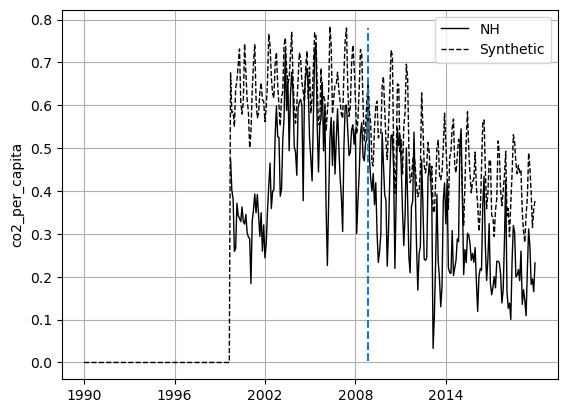

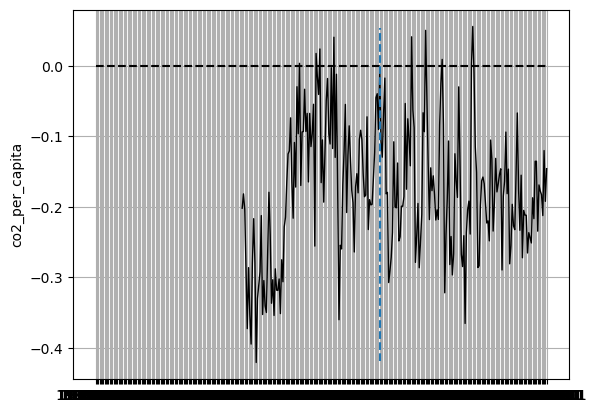

In [41]:
# Monthly synthetic control plot

synth_mo.path_plot(time_period=years, treatment_time=treatment_dates[0])
synth_mo.gaps_plot(time_period=years, treatment_time=treatment_dates[0])

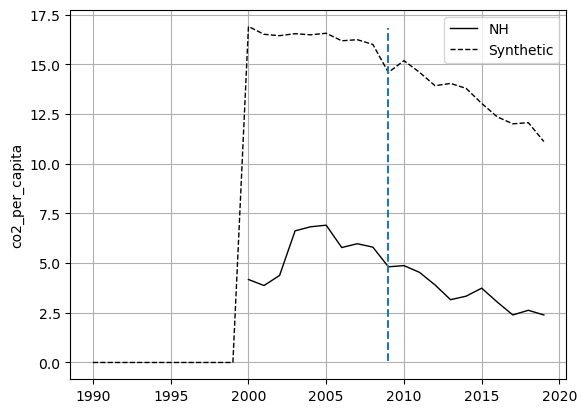

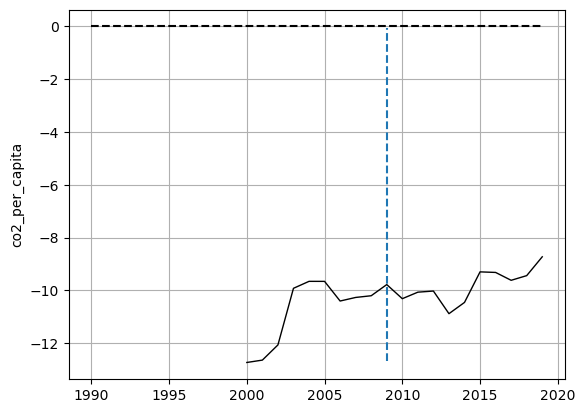

In [42]:
# Yearly synthetic control plot

synth_yr.path_plot_orig(time_period=range(1990,2020), treatment_time=2009)
synth_yr.gaps_plot(time_period=range(1990,2020), treatment_time=2009)

The summary function give more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [43]:
synth_mo.summary()

,V,treated,synthetic,sample mean
monthly_num_plants,0.143,4.486,16.142,21.663
special.1.eprod_per_capita,0.143,0.008,0.007,0.069
special.2.eflow_per_capita,0.143,-0.012,-0.022,0.036
special.3.gdp_per_capita,0.143,0.004,0.004,0.004
special.4.monthly_pop_density,0.143,0.007,0.016,0.033
special.5.yearly_renew_pct,0.143,0.084,0.151,0.105
special.6.yearly_fossil_pct,0.143,0.359,0.516,0.729


In [44]:
synth_yr.summary()

,V,treated,synthetic,sample mean
yearly_num_plants,0.111,2.750,17.279,17.279
special.1.eprod_per_capita,0.111,0.090,0.773,0.773
special.2.eflow_per_capita,0.111,-0.154,0.367,0.367
special.3.gdp_per_capita,0.111,0.049,0.044,0.044
special.4.yearly_pop_density,0.111,0.008,0.034,0.034
special.5.co2_per_capita,0.111,NaN,0.000,NaN
special.6.co2_per_capita,0.111,4.177,16.911,16.911
special.7.yearly_renew_pct,0.111,0.103,0.114,0.114
special.8.yearly_fossil_pct,0.111,0.318,0.717,0.717


## RGGI State Synthetic Control Comparisons

First, we compare the RGGI synthetic controls at the monthly level.

In [45]:
# loop through all RGGI states to see their monthly graphs

for state in rggi_states:
    dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['monthly_num_plants'], 
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_energy_range, "mean"),
        ('eflow_per_capita', preintervention_energy_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ('yearly_renew_pct', preintervention_energy_range, "mean"),
        ('yearly_fossil_pct', preintervention_energy_range, "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state,
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
    )

    # monthly version

    synth_mo = Synth()
    synth_mo.fit(dataprep=dataprep_mo)

    synth_mo.path_plot(time_period=years, treatment_time=treatment_dates[0])
    synth_mo.gaps_plot(time_period=years, treatment_time=treatment_dates[0])
    print('State:', state,'\n')
    print(synth_mo.weights(threshold=.01),'\n')
    print(synth_mo.summary())

KeyboardInterrupt: 